In [154]:
import pandas as pd
import numpy as np

In [155]:
df = pd.read_csv('diabetes.csv')
X = df.loc[:, df.columns != 'Outcome']
Y_raw = df['Outcome']

Проверим тип данных и баланс классов:

In [156]:
X.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
dtype: object

In [157]:
print(X[Y_raw == 1].shape[0] / X.shape[0])

0.3489583333333333


Классы несбалансированы и размер датасета сравнительно мал, поэтому я решил использовать SMOTE для оверсемплинга:

In [158]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X=X)

oversample = SMOTE(random_state=42)
X, Y = oversample.fit_resample(X_scaled, Y_raw)

Я тренирую каждую модель по данным с оверсеплингом, затем преверяю точность модели по исходным данным.

In [159]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from statistics import mean, stdev


def cross_validation(model, acc_list, X, y):

  skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

  for train_index, test_index in skf.split(X, y):

      x_train_fold, _ = X[train_index], X[test_index]
      y_train_fold, _ = y[train_index], y[test_index]

      model.fit(x_train_fold, y_train_fold)


      _, X_test, _, Y_test = train_test_split(X_scaled, Y_raw, test_size=0.25, random_state=42)

      acc_list.append(round(model.score(X_test, Y_test), 2))


model_names = ('Decision Tree', 'Random Forest', 'SVC', 'SGD', 'GaussianNB')
acc_list = []
models = [DecisionTreeClassifier(),
          RandomForestClassifier(),
          SVC(),
          SGDClassifier(),
          GaussianNB()]

for model in models:
  model_acc = []
  cross_validation(model, model_acc, X, Y)
  acc_list.append(model_acc)


[('Decision Tree', 0.974), ('Random Forest', 0.9760000000000002), ('SVC', 0.7860000000000001), ('SGD', 0.7070000000000001), ('GaussianNB', 0.7380000000000001)]


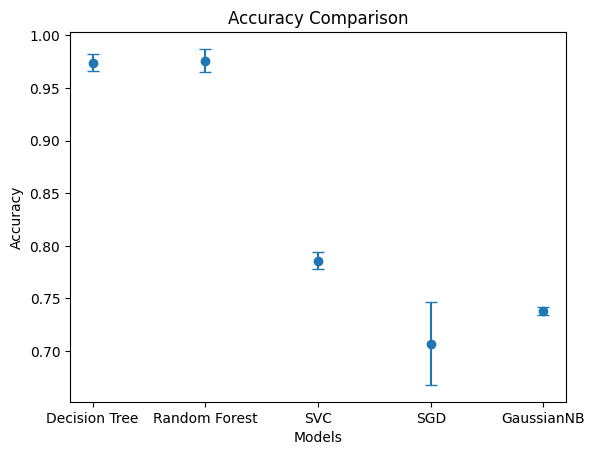

In [160]:
import matplotlib.pyplot as plt

def draw_error_bars(accuracies):
    num_models = len(accuracies)
    x = range(num_models)
    means = [sum(acc) / len(acc) for acc in accuracies]
    stds = [np.std(acc) for acc in accuracies]

    print(list(zip(model_names, means)))

    plt.errorbar(x, means, yerr=stds, fmt='o', capsize=4)

    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison')
    plt.xticks(x, labels=model_names)
    plt.grid(False)

    plt.show()


draw_error_bars(acc_list)

На графике выше можно заметить, что лучше всего себя показывают деревья решений и случайные леса.

In [161]:
import tensorflow as tf
from tensorflow.keras import layers


In [162]:
X.shape

(1000, 8)

In [163]:
network_layers = (tf.keras.Input(shape=8),
          layers.Dense(units=128, activation='relu'),
          layers.Dropout(0.2),
          layers.Dense(units=128, activation='relu'),
          layers.BatchNormalization(axis=1),
          layers.Dense(128, activation='relu'),
          layers.Dropout(0.2),
          layers.Dense(units=2, activation='softmax'))


In [164]:
classifier = tf.keras.Sequential(layers=network_layers, name=None)
classifier.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 128)               1152      
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_33 (Dense)            (None, 128)               16512     
                                                                 
 batch_normalization_4 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_34 (Dense)            (None, 128)               16512     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                     

In [165]:
classifier.compile(optimizer='adam', metrics='accuracy', loss=tf.keras.losses.SparseCategoricalCrossentropy())

In [166]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

In [167]:
history = classifier.fit(X_train, Y_train, epochs=100)

Epoch 1/100
27/27 [==============================] - 1s 3ms/step - loss: 0.6150 - accuracy: 0.7294
Epoch 2/100
27/27 [==============================] - 0s 3ms/step - loss: 0.5023 - accuracy: 0.7659
Epoch 3/100
27/27 [==============================] - 0s 3ms/step - loss: 0.4571 - accuracy: 0.7965
Epoch 4/100
27/27 [==============================] - 0s 3ms/step - loss: 0.4643 - accuracy: 0.7847
Epoch 5/100
27/27 [==============================] - 0s 3ms/step - loss: 0.4236 - accuracy: 0.8118
Epoch 6/100
27/27 [==============================] - 0s 3ms/step - loss: 0.4519 - accuracy: 0.8059
Epoch 7/100
27/27 [==============================] - 0s 3ms/step - loss: 0.4395 - accuracy: 0.7953
Epoch 8/100
27/27 [==============================] - 0s 3ms/step - loss: 0.4239 - accuracy: 0.8035
Epoch 9/100
27/27 [==============================] - 0s 3ms/step - loss: 0.4043 - accuracy: 0.8071
Epoch 10/100
27/27 [==============================] - 0s 3ms/step - loss: 0.3922 - accuracy: 0.8259
Epoch 11/

In [168]:
_, X_test, _, Y_test = train_test_split(X_scaled, Y_raw, test_size=0.25, random_state=42)

In [169]:
classifier.evaluate(X_test, Y_test)

6/6 [==============================] - 0s 3ms/step - loss: 0.4159 - accuracy: 0.8906


[0.41594207286834717, 0.890625]

Точность классификации с использованием нейронной сети составила 0.91, что ниже, чем у деревьев решений. Такой показатель является ожидаемым, потому что в исходном массиве данных всего 8 признаков, и использование нейросети здесь не целесообразно.